InvoiceNo
StockCode
Description
Quantity
InvoiceDate
UnitPrice
CustomerID
Country
541909
2010년 12월
2011년 1월
2011년 2월
2011년 3월
2011년 4월
2011년 5월
2011년 6월
2011년 7월
2011년 8월
2011년 9월
2011년 10월
2011년 11월
2011년 12월


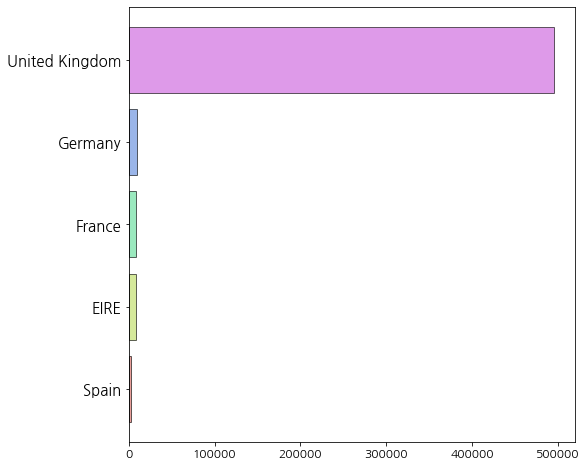

In [4]:
########### RFM 분석 ############
##### 모듈 임포트
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from collections import Counter
from tqdm import tqdm

##### 데이터 보기
df = pd.read_csv('ecommerce-data.csv', encoding = 'ISO-8859-1') ## 인코딩 지정 안해주면 에러남

## 칼럼보기
for col in df.columns:
    print(col)
    
## 데이터 개수
print(len(df))

## 기간 보기
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) ## 문자열로된 날짜를 Timestamp형식으로 변환
 
set_of_year_month = list(set([(x.year, x.month) for x in df['InvoiceDate']])) ## 송장날짜에서 연도와 월정보를 가져온다.
for ym in sorted(set_of_year_month, key=lambda x: (x[0], x[1])): ## 연도와 월정보를 연도, 월 순으로 출력 
    print(f'{ym[0]}년 {ym[1]}월')
    
## 나라별 데이터 보기
nation_data = Counter(df['Country']).most_common() ## 데이터 개수가 많은 순으로 출력
nation_data = nation_data[:5] ## 상위 5개만 저장
 
data = [x[1] for x in nation_data] ## 데이터 개수
nations = [x[0] for x in nation_data] ## 국가
 
## 수평 바차트에서 데이터 개수와 나라를 맨위로 출력하기 위해서 리스트 순서를 바꿈
nations.reverse()
data.reverse()
 
## 시각화
fig =plt.figure(figsize=(8,8))
 
fig.set_facecolor('white') ## 캔버스 색깔
colors = sns.color_palette('hls',len(data)) ## color 생성
plt.yticks(fontsize=15) # y축 눈금 라벨 폰트사이즈 설정
plt.xticks(fontsize=12) # x축 눈금 라벨 폰트사이즈 설정
 
plt.barh(nations, data, color=colors,alpha=0.6,edgecolor='k') ## 수평바차트 생성
plt.show()

In [5]:
##### 필요 함수 정의
def get_score(level, data):
    '''
    Description :
    level안에 있는 원소를 기준으로
    1 ~ len(level)+ 1 까지 점수를 부여하는 함수
    
    Parameters :
    level = 튜플 또는 리스트 타입의 숫자형 데이터이며 반드시 오름차순으로 정렬되어 있어야함.
    예 - [1,2,3,4,5] O, [5,4,3,2,1] X, [1,3,2,10,4] X 
    data = 점수를 부여할 데이터. 순회가능한(iterable) 데이터 형식
    return :
    점수를 담고 있는 리스트 반환
    '''
    score = [] 
    for j in range(len(data)): 
        for i in range(len(level)): 
            if data[j] <= level[i]: 
                score.append(i+1) 
                break 
            elif data[j] > max(level): 
                score.append(len(level)+1) 
                break 
            else: 
                continue 
    return score 

def get_rfm_grade(df, num_class, rfm_tick_point, rfm_col_map, suffix=None):
    '''
    Description :
    개별 고객에 대한 최근방문일/방문횟수/구매금액 데이터가 주어졌을때
    최근방문일/방문횟수/구매금액 점수를 계산하여 주어진 데이터 오른쪽에 붙여줍니다.
    
    Parameters :
    df = pandas.DataFrame 데이터
    num_class = 등급(점수) 개수
    rfm_tick_point = 최근방문일/방문횟수/구매금액에 대해서 등급을 나눌 기준이 되는 값
                    'quantile', 'min_max' 또는 리스트를 통하여 직접 값을 정할 수 있음.
                    단, 리스트 사용시 원소의 개수는 반드시 num_class - 1 이어야함.
                    quatile = 데이터의 분위수를 기준으로 점수를 매김
                    min_max = 데이터의 최소값과 최대값을 동일 간격으로 나누어 점수를 매김
    rfm_col_map = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명
    예 - {'R':'Recency','F':'Frequency','M':'Monetary'}
    suffix = 최근방문일/방문횟수/구매금액에 대응하는 칼럼명 뒤에 붙는 접미사
    Return : 
    pandas.DataFrame
    '''
    ##### 필요모듈 체크
    import pandas as pd
    import numpy as np
    from sklearn import preprocessing
    
    ##### 파라미터 체크
    if not isinstance(df, pd.DataFrame): ## 데이터는 pd.DataFrame이어야 함.
        print('데이터는 pandas.DataFrame 객체여야 합니다.')
        return
    
    if isinstance(rfm_tick_point, dict) == False or isinstance(rfm_col_map, dict) == False: ## rfm_tick_point와 rfm_col_map은 모두 딕셔너리
        print(f'rfm_tick_point와 rfm_col_map은 모두 딕셔너리여야합니다.')
        return
    
    if len(rfm_col_map) != 3: ## rfm_col_map에는 반드시 3개의 키를 가져아함.
        print(f'rfm_col_map인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if len(rfm_tick_point) != 3: ## rfm_tick_point에는 반드시 3개의 키를 가져아함.
        print(f'rfm_tick_point인자는 반드시 3개의 키를 가져야합니다. \n현재 rfm_col_map에는 {len(rfm_col_map)}개의 키가 있습니다.')
        return
    
    if set(rfm_tick_point.keys()) != set(rfm_col_map.keys()): ## rfm_tick_point와 rfm_col_map은 같은 키를 가져야함.
        print(f'rfm_tick_point와 rfm_col_map은 같은 키를 가져야 합니다.')
        return
    
    if not set(rfm_col_map.values()).issubset(set(df.columns)):
        not_in_df = set(rfm_col_map.values())-set(df.columns)
        print(f'{not_in_df}이 데이터 칼럼에 있어야 합니다.')
        return
    
    for k, v in rfm_tick_point.items():
        if isinstance(v, str):
            if not v in ['quantile','min_max']:
                print(f'{k}의 값은 "quantile" 또는 "min_max"중에 하나여야 합니다.')
                return
        elif isinstance(v,list) or isinstance(v,tuple):
            if len(v) != num_class-1:
                print(f'{k}에 대응하는 리스트(튜플)의 원소는 {num_class-1}개여야 합니다.')
                return
    
    if suffix:
        if not isinstance(suffix, str):
            print('suffix인자는 문자열이어야합니다.')
            return
        
    ##### 최근방문일/방문횟수/구매금액 점수 부여
    for k, v in rfm_tick_point.items():
        if isinstance(v,str):
            if v == 'quantile':
                ## 데이터 변환
                scale = preprocessing.StandardScaler() ## 데이터의 범위 조작하기 쉽게 해주는 클래스 
                temp_data = np.array(df[rfm_col_map[k]]) ## 데이터를 Numpy 배열로 변환
                temp_data = temp_data.reshape((-1,1)) ## scale을 적용하기위해 1차원 배열을 2차원으로 변환
                temp_data = scale.fit_transform(temp_data) ## 데이터를 평균은 0, 표준편차는 1을 갖도록 변환 
                temp_data = temp_data.squeeze() ## 데이터를 다시 1차원으로 변환

                ## 분위수 벡터
                quantiles_level = np.linspace(0,1,num_class+1)[1:-1] ## 분위수를 구할 기준값을 지정 0과 1은 제외
                quantiles = [] ## 분위수를 담을 리스트
                for ql in quantiles_level:
                    quantiles.append(np.quantile(temp_data,ql)) ## 분위수를 계산하고 리스트에 삽입
            else: ## min_max인 경우
                ## 데이터 변환
                temp_data = np.array(df[rfm_col_map[k]])

                ## 등분점 계산
                quantiles = np.linspace(np.min(temp_data),np.max(temp_data),num_class+1)[1:-1] ## 최소값과 최대값을 점수 개수만큼 등간격으로 분할하는 점
        else: ## 직접 구분값을 넣어주는 경우
            temp_data = np.array(df[rfm_col_map[k]])
            quantiles = v ## 직접 구분값을 넣어줌
        score = get_score(quantiles, temp_data) ## 구분값을 기준으로 점수를 부여하고 리스트로 저장한다.
        new_col_name = rfm_col_map[k]+'_'+k ## 점수값을 담는 변수의 이름
        if suffix:
            new_col_name = rfm_col_map[k]+'_'+suffix
        df[new_col_name] = score ## 기존데이터 옆에 점수 데이터를 추가한다.
    return df

In [6]:
######### 데이터 전처리 & 데이터 분석
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) ## 문자열로된 날짜를 Timestamp형식으로 변환

## 분석할 나라와 연도 설정
target_country = 'United Kingdom'
target_year = '2011'

df = df.query('Country == @target_country and InvoiceDate.dt.year == @target_year')

## 필요한 칼럼 추출
df = df[['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']]

## 결측값 처리
# df.info() ## 결측값 1차 확인
df = df.dropna()
# df.info() ## 결측값 2차 확인

## 구매 취소 데이터 삭제

## 송장번호 앞에 'C'가 있으면 삭제 구매취소된 데이터를 의미한다. 여기서는 단순히 'C'가 있는지 없는지만 보면된다.
df = df.query('InvoiceNo.str.get(0) != "C"')

customer_id = list(df['CustomerID'].unique()) ## 고객아이디

## 먼저 각 고객별로 구매금액이 얼마인지 알아보자.
monetary_df = pd.DataFrame() ## 구매금액 데이터 초기화
monetary_df['CustomerID'] = customer_id ## 고객아이디 삽입

monetary_data = [] ## 구매금액을 담을 리스트
for ci in tqdm(customer_id,position=0,desc='Calculating amount of individual customer'):
    temp = df.query('CustomerID==@ci') ## 해당 아이디의 고객데이터 추출
    amount = sum(temp['Quantity'] * temp['UnitPrice']) ## 해당 고객 구매금액
    monetary_data.append(amount)
    
monetary_df['Monetary'] = monetary_data ## 구매금액 데이터 삽입

## 각 고객별 최근방문일을 알아보자.
temp_recency_df = df[['CustomerID','InvoiceDate']].drop_duplicates() ## 고객 아이디와 송장날짜만 추출한뒤 중복 제거
recency_df = temp_recency_df.groupby('CustomerID')['InvoiceDate'].max().reset_index() ## 아이디로 그룹화 한다음 최근방문일을 구해야 하므로 송장날짜에 max를 적용한다.
recency_df = recency_df.rename(columns={'InvoiceDate':'Recency'})

## 각 고객별 방문횟수를 알아보자.
temp_frequency_df = df[['CustomerID','InvoiceNo']].drop_duplicates() ## 고객 아이디와 송장번호만 추출한뒤 중복 제거
frequency_df = temp_frequency_df.groupby('CustomerID')['InvoiceNo'].count().reset_index() ## 아이디로 그룹화 한다음 방문횟수를 구해야 한다. 여기서는 방문횟수를 송장번호 개수로 생각했으므로 송장번호에 count를 적용한다.
frequency_df = frequency_df.rename(columns={'InvoiceNo':'Frequency'})

## 데이터를 고객아이디를 기준으로 합쳐야한다.
rfm_df = pd.merge(recency_df,frequency_df,how='left',on='CustomerID')
rfm_df = pd.merge(rfm_df,monetary_df,how='left',on='CustomerID')

## 데이터 변환
current_day = pd.to_datetime('20110101') ## 기준 날짜를 2011년 1월 1일 0시 0분으로 잡았다.
time_diff = rfm_df['Recency']-current_day ## 최근방문일과 기준 날짜의 시간 차이
time_in_seconds = [x.total_seconds() for x in time_diff] ## 시간 차이를 초단위로 계산
rfm_df['Recency'] = time_in_seconds ## 변환된 데이터를 다시 삽입한다.

Calculating amount of individual customer: 100%|██████████████████████████████████| 3814/3814 [00:15<00:00, 238.45it/s]


In [7]:
##### 점수 계산
rfm_tick_point={'R':'quantile','F':'quantile','M':'quantile'}
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}

result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result[['CustomerID','Recency_R','Frequency_F','Monetary_M']]

,CustomerID,Recency_R,Frequency_F,Monetary_M
0,12346.0,1,2,5
1,12747.0,5,5,5
2,12748.0,5,5,5
3,12749.0,5,4,5
4,12820.0,5,4,4
...,...,...,...,...
3809,18280.0,1,2,1
3810,18281.0,1,2,1
3811,18282.0,5,2,1
3812,18283.0,5,5,5


In [ ]:
######### 사용 예제
rfm_tick_point={'R':'quantile','F':'quantile','M':'min_max'} ## 구매금액에 최소값 최대값을 이용한 방법 적용
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}

result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result[['CustomerID','Recency_R','Frequency_F','Monetary_M']]

In [ ]:
rfm_tick_point={'R':'quantile','F':[5, 10, 50, 90],'M':'quantile'} ## 방문 횟수에 직접 기준값을 정하는 방법 적용
rfm_col_map={'R':'Recency','F':'Frequency','M':'Monetary'}

result = get_rfm_grade(df=rfm_df, num_class=5, rfm_tick_point=rfm_tick_point, rfm_col_map=rfm_col_map)
result[['CustomerID','Recency_R','Frequency_F','Monetary_M']]